# Enhancer-gene linking with correlation + modules

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# System:
import os
import re
import csv
import gzip
import time
import datetime
import sys
import gc
import six.moves.cPickle as pickle
from tqdm import tqdm, tqdm_notebook
from IPython import get_ipython
ipython_shell = get_ipython()

# Math 
import scipy.stats as st
import numpy as np
from scipy.cluster import hierarchy as sch

# Plotting:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec, ticker, markers
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from IPython import display
from polo import optimal_leaf_ordering
from scipy import sparse

# Local paths and functions:
import auxfunc_masterlist as AUX
import load_linking_data as LLD
import parse_config

# For random data:
rng = np.random

# For plot points
from scipy.sparse import coo_matrix, csr_matrix
import pandas as pd, numpy as np
from collections import OrderedDict as odict

# Logic:
import pyranges as pr

# Style
sns.set(style="ticks", color_codes=True)

/EPIMAP_ANALYSIS/bin
[STATUS] Loaded config correctly.


In [2]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## Load data for linking

In [3]:
loader = LLD.load_linking_data()

In [4]:
loader.load_matrices()

[STATUS] Loading matrices x5


In [5]:
loader.load_annotations()

[STATUS] Loading annotations/metadata
[STATUS] Reordering coordinates list to match matrices
[STATUS] Loading gene annotations
[STATUS] Making dataframe for testing E-P pairs
[STATUS] Created links testset with 33,693,827 possible links in +/- 1MB


Text(0, 0.5, 'Number of enhancers')

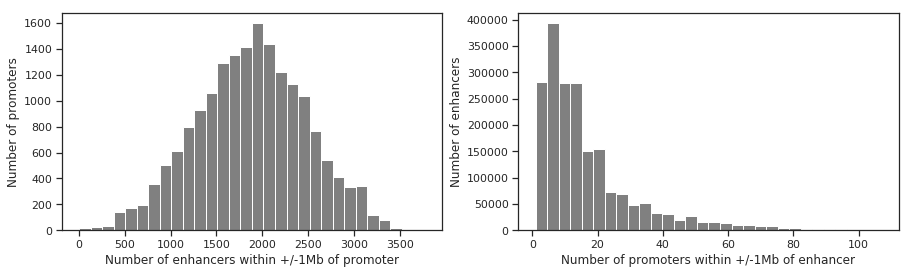

In [6]:
# NOTE: Visualize how many interactions we are testing:
plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(ncols=2, nrows=1)
plt.subplot(gs[0])
u, c = np.unique(loader.pairsdf.cls_promind, return_counts=True)
h = plt.hist(c, 30, color='grey')
plt.xlabel('Number of enhancers within +/-1Mb of promoter')
plt.ylabel('Number of promoters')

plt.subplot(gs[1])
u, c = np.unique(loader.pairsdf.cls_enhind, return_counts=True)
h = plt.hist(c, 30, color='grey')
plt.xlabel('Number of promoters within +/-1Mb of enhancer')
plt.ylabel('Number of enhancers')

In [7]:
loader.load_GTEx_eQTLs()

[STATUS] Trying to load qtls from cp file
[STATUS] Assigning qtls to enhancers
[STATUS] Unique promoter - enhancer reduced QTLs to 1,555,029 QTL links
[STATUS] Merge with test links creates final dataset: 1,555,009 QTL links in 33,693,827 total possible links


In [8]:
loader.load_pchic()

[STATUS] Unique promoter - enhancer PCHiC interactions: 445,957
[STATUS] Merge with test links: 398,405 PCHiC links in 33,693,827 total possible links


In [9]:
loader.load_rmlinks()

[STATUS] Loading Roadmap links
[STATUS] Start with: 1,008,646 links
[STATUS] After merge, 606,607 links
[STATUS] Merge with test links: 606,598 Roadmap links in 33,697,479 total possible links


In [10]:
loader.testdf.head()

,cls_promind,cls_enhind,isqtl,ispc,isrm
0,605,538,1.0,0.0,0.0
1,2588,538,1.0,0.0,0.0
2,3688,538,1.0,0.0,0.0
3,2275,538,0.0,0.0,0.0
4,2274,538,0.0,0.0,0.0


In [11]:
print(round(len(loader.testdf) / np.sum(loader.testdf.isqtl), 2))
print(round(len(loader.testdf) / np.sum(loader.testdf.ispc), 2))

21.65
84.57


In [12]:
print('Unique ENH:', len(pd.unique(loader.testdf.cls_enhind)))
print('Unique PROM:', len(pd.unique(loader.testdf.cls_promind)))

Unique ENH: 1993405
Unique PROM: 17940


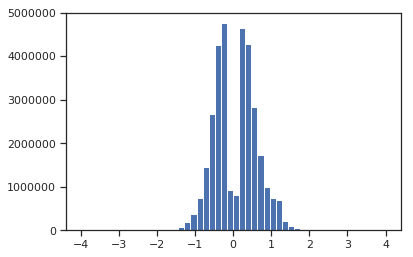

In [13]:
ss = loader.qtldf.slope
ss = ss[ss < 4]
ss = ss[ss > -4]
h = plt.hist(ss, 50)

In [14]:
# For links:
def print_pr(oracle, pred):
    if hasattr(oracle, 'name') and hasattr(pred, 'name'):
        print("Oracle: " + oracle.name + " vs. pred: " + pred.name)
    RECALL = np.sum(pred * oracle) / np.sum(oracle)
    PRECISION = np.sum(pred * oracle) / np.sum(pred)
    print("RECALL:", round(RECALL * 100, 2))
    print("PRECISION:", round(PRECISION * 100, 2))
    print("ORACLE:", "{:,}".format(int(np.sum(oracle,0))))
    print("PRED:", "{:,}".format(int(np.sum(pred,0))))
    print("---------------")

In [15]:
print_pr(loader.testdf.isqtl, loader.testdf.ispc)
print_pr(loader.testdf.isqtl, loader.testdf.isrm)
print_pr(loader.testdf.ispc, loader.testdf.isrm)

Oracle: isqtl vs. pred: ispc
RECALL: 2.29
PRECISION: 8.96
ORACLE: 1,556,284
PRED: 398,479
---------------
Oracle: isqtl vs. pred: isrm
RECALL: 10.02
PRECISION: 25.7
ORACLE: 1,556,284
PRED: 606,598
---------------
Oracle: ispc vs. pred: isrm
RECALL: 4.07
PRECISION: 2.67
ORACLE: 398,479
PRED: 606,598
---------------


### [M1] Baseline: link each enhancer to its nearest gene:

In [16]:
# Merge midpts:
loader.midmap.columns = ['cls_promind','mid_prom']
loader.testdf = loader.testdf.merge(loader.midmap)
loader.midmap.columns = ['cls_enhind','mid_enh']
loader.testdf = loader.testdf.merge(loader.midmap)
loader.testdf.head()

# Get distance for each and select by enhancer:
loader.testdf['dist'] = np.abs(np.diff(loader.testdf.loc[:,['mid_prom','mid_enh']], axis=1))
emindf = pd.DataFrame(loader.testdf.groupby('cls_enhind')['dist'].min())
emindf.reset_index(level=0, inplace=True)
emindf['isnearest'] = 1
loader.testdf = loader.testdf.merge(emindf, how='left')
loader.testdf.fillna(0, inplace=True)
print_pr(loader.testdf.isqtl, loader.testdf.isnearest)
print_pr(loader.testdf.ispc, loader.testdf.isnearest)
print_pr(loader.testdf.isrm, loader.testdf.isnearest)

Oracle: isqtl vs. pred: isnearest
RECALL: 24.23
PRECISION: 18.9
ORACLE: 1,556,284
PRED: 1,995,402
---------------
Oracle: ispc vs. pred: isnearest
RECALL: 9.77
PRECISION: 1.95
ORACLE: 398,479
PRED: 1,995,402
---------------
Oracle: isrm vs. pred: isnearest
RECALL: 49.73
PRECISION: 15.12
ORACLE: 606,598
PRED: 1,995,402
---------------


### [M1b] Baseline: link each promoter to its nearest enhancer:

In [17]:
emindf = pd.DataFrame(loader.testdf.groupby('cls_promind')['dist'].min())
emindf.reset_index(level=0, inplace=True)
emindf['isPnearest'] = 1
loader.testdf = loader.testdf.merge(emindf, how='left')
loader.testdf.fillna(0, inplace=True)
print_pr(loader.testdf.isqtl, loader.testdf.isPnearest)
print_pr(loader.testdf.ispc, loader.testdf.isPnearest)
print_pr(loader.testdf.isrm, loader.testdf.isPnearest)

Oracle: isqtl vs. pred: isPnearest
RECALL: 0.38
PRECISION: 32.77
ORACLE: 1,556,284
PRED: 18,043
---------------
Oracle: ispc vs. pred: isPnearest
RECALL: 0.0
PRECISION: 0.1
ORACLE: 398,479
PRED: 18,043
---------------
Oracle: isrm vs. pred: isPnearest
RECALL: 1.25
PRECISION: 42.15
ORACLE: 606,598
PRED: 18,043
---------------


### [M2] Modules: link each enhancer to its nearest gene within module match:
- Alternate - all modules within corr

In [18]:
# NOTE: Big issue is that not all promoters are annotated with a module!
loader.load_cluster_annotations()
loader.match_clusters()

In [19]:
# Add module for each and their similarity:
loader.testdf = loader.testdf.merge(loader.eclsdf)
loader.testdf = loader.testdf.merge(loader.pclsdf)
loader.testdf = loader.testdf.merge(loader.moddf)
loader.testdf.head()

,cls_promind,cls_enhind,isqtl,ispc,isrm,mid_prom,mid_enh,dist,isnearest,isPnearest,id_enh,id_prom,mod_sim
0,605,538,1.0,0.0,0.0,714130.0,713343.5,786.5,1.0,1.0,247,15,0.013301
1,605,1071,0.0,0.0,0.0,714130.0,1353460.0,639330.0,0.0,0.0,247,15,0.013301
2,605,1072,0.0,0.0,0.0,714130.0,1353613.0,639483.0,0.0,0.0,247,15,0.013301
3,605,1097,0.0,0.0,0.0,714130.0,1359380.0,645250.0,0.0,0.0,247,15,0.013301
4,605,1409,0.0,0.0,0.0,714130.0,1519150.0,805020.0,0.0,0.0,247,15,0.013301


In [20]:
# See how poorly module matching does.
mmdf = pd.DataFrame(loader.moddf.groupby(['id_enh'])['mod_sim'].max())
mmdf.reset_index(level=0, inplace=True)
mmdf['isMnearest'] = 1
loader.testdf = loader.testdf.merge(mmdf, how='left')
loader.testdf.fillna(0, inplace=True)
print_pr(loader.testdf.isqtl, loader.testdf.isMnearest)
print_pr(loader.testdf.ispc, loader.testdf.isMnearest)
print_pr(loader.testdf.isrm, loader.testdf.isMnearest)

Oracle: isqtl vs. pred: isMnearest
RECALL: 4.41
PRECISION: 3.6
ORACLE: 1,286,065
PRED: 1,575,412
---------------
Oracle: ispc vs. pred: isMnearest
RECALL: 5.08
PRECISION: 1.16
ORACLE: 360,423
PRED: 1,575,412
---------------
Oracle: isrm vs. pred: isMnearest
RECALL: 9.34
PRECISION: 2.87
ORACLE: 484,136
PRED: 1,575,412
---------------


In [21]:
mmdf = pd.DataFrame(loader.testdf.groupby(['cls_enhind'])['mod_sim'].max())
mmdf.reset_index(level=0, inplace=True)
mmdf['isMmax'] = 1
loader.testdf = loader.testdf.merge(mmdf, how='left')
loader.testdf.fillna(0, inplace=True)
print_pr(loader.testdf.isqtl, loader.testdf.isMmax)
print_pr(loader.testdf.ispc, loader.testdf.isMmax)
print_pr(loader.testdf.isrm, loader.testdf.isMmax)

Oracle: isqtl vs. pred: isMmax
RECALL: 52.57
PRECISION: 5.31
ORACLE: 1,286,065
PRED: 12,730,717
---------------
Oracle: ispc vs. pred: isMmax
RECALL: 56.3
PRECISION: 1.59
ORACLE: 360,423
PRED: 12,730,717
---------------
Oracle: isrm vs. pred: isMmax
RECALL: 55.63
PRECISION: 2.12
ORACLE: 484,136
PRED: 12,730,717
---------------


In [22]:
elist = np.array(loader.testdf.cls_enhind)
ee = elist[loader.testdf.isMnearest == 1]
em = elist[loader.testdf.isMmax == 1]
print(LLD.fmtcm(len(np.unique(elist))))
print(LLD.fmtcm(len(np.unique(ee))))
print(LLD.fmtcm(len(np.unique(em))))

1,981,566
128,761
1,981,566


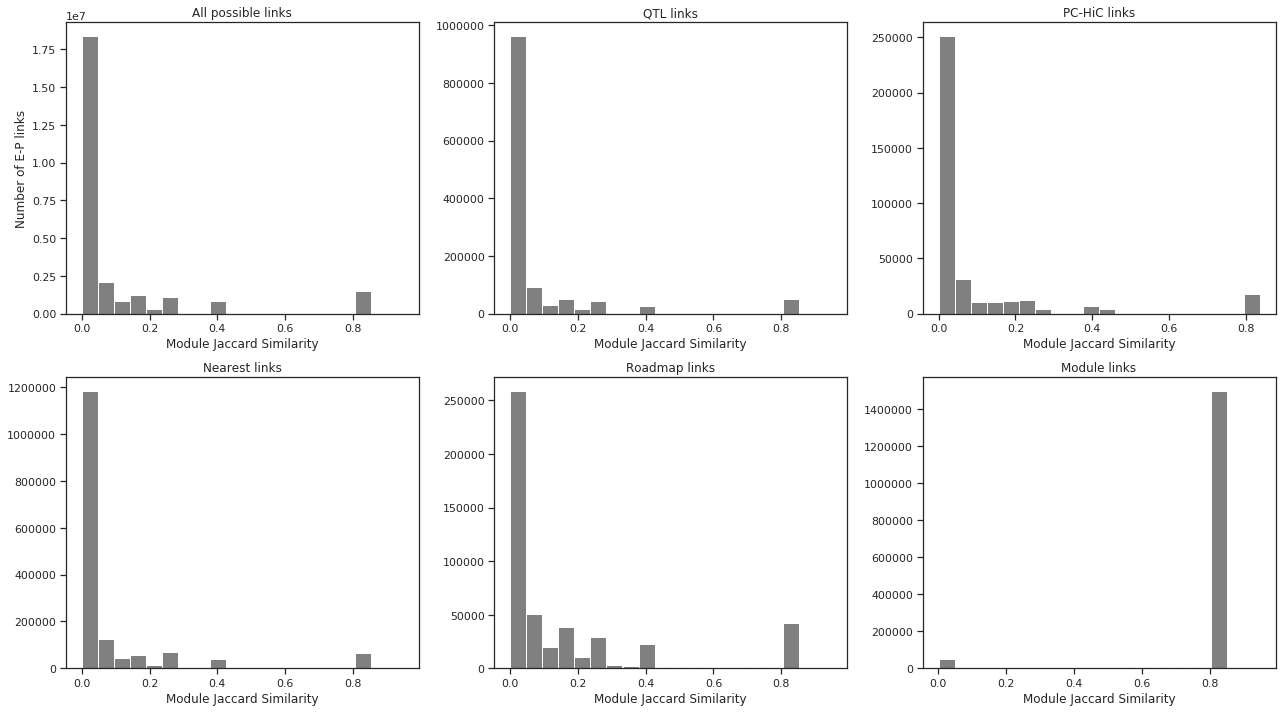

In [23]:
# See how close module similarities are for QTL links vs. not:
plt.figure(figsize=(18,10))
gs = gridspec.GridSpec(ncols=3, nrows=2)
plt.subplot(gs[0])
h = plt.hist(loader.testdf.mod_sim, 20, color='grey')
plt.xlabel('Module Jaccard Similarity')
plt.ylabel('Number of E-P links')
plt.title('All possible links')

plt.subplot(gs[1])
h = plt.hist(loader.testdf.mod_sim.loc[loader.testdf.isqtl==1], 20, color='grey')
plt.xlabel('Module Jaccard Similarity')
plt.title('QTL links')

plt.subplot(gs[2])
h = plt.hist(loader.testdf.mod_sim.loc[loader.testdf.ispc ==1], 20, color='grey')
plt.xlabel('Module Jaccard Similarity')
plt.title('PC-HiC links')

plt.subplot(gs[3])
h = plt.hist(loader.testdf.mod_sim.loc[loader.testdf.isnearest==1], 20, color='grey')
plt.xlabel('Module Jaccard Similarity')
plt.title('Nearest links')

plt.subplot(gs[4])
h = plt.hist(loader.testdf.mod_sim.loc[loader.testdf.isrm==1], 20, color='grey')
plt.xlabel('Module Jaccard Similarity')
plt.title('Roadmap links')

plt.subplot(gs[5])
h = plt.hist(loader.testdf.mod_sim.loc[loader.testdf.isMnearest==1], 20, color='grey')
plt.xlabel('Module Jaccard Similarity')
plt.title('Module links')
plt.tight_layout()

#### Set up distance calcs:

In [24]:
from scipy.spatial import distance

# Set up matrix
acX = loader.h1X.copy()
acX.data = np.log2(acX.data)

epX = loader.eX.multiply(acX)
ppX = loader.pX.multiply(acX)

def zscore(x):
    mu = np.mean(x)
    sd = np.std(x)
    z = (x - mu)/sd
    return(z)

#### Verify tissue specificity for QTLs:
- AGGREGATE TISSUE SPEC for PROMOTERS and for ENHANCERS per GTEx tissue - plot as 2 x 2 heatmaps (annotations with and without H3K27ac?)

In [ ]:
# Initialize
loader.qtltisdf = loader.qtltisdf.drop_duplicates()
ut = np.sort(pd.unique(loader.qtltisdf.tissue))
NU = len(ut)
ecnt = np.zeros((acX.shape[1], NU))
pcnt = np.zeros((acX.shape[1], NU))
eacnt = np.zeros((acX.shape[1], NU))
pacnt = np.zeros((acX.shape[1], NU))

# Process tissues:
for i in tqdm_notebook(range(NU)):
    tissue = ut[i]
    tid = np.where(loader.qtltisdf.tissue == tissue)[0]
    eind = np.array(loader.qtltisdf.cls_enhind.iloc[tid])  # Make np array othw may index by indexes??
    pind = np.array(loader.qtltisdf.cls_promind.iloc[tid])
    ecnt[:,i] =  np.array(np.mean(loader.eX[eind,:], axis=0))[0].T
    pcnt[:,i] =  np.array(np.mean(loader.pX[pind,:], axis=0))[0].T
    eacnt[:,i] =  np.array(np.mean(epX[eind,:], axis=0))[0].T
    pacnt[:,i] =  np.array(np.mean(ppX[pind,:], axis=0))[0].T

In [ ]:
# Order the imputed tissues by frozen order:
tord = np.array(pd.read_csv(loader.orderfile, header=None)).T[0]
tord = [t for t in tord if t in loader.enam]
eord = np.array([np.where(np.array(loader.enam) == n)[0][0] for n in tord])

#### Visualize cell specificity:

In [ ]:
# Do not seem to have very much specificity:
plt.figure(figsize=(20,12))
gs = gridspec.GridSpec(ncols=1, nrows=4)
plt.subplot(gs[0])
sns.heatmap(ecnt[eord,:].T, vmin=0, vmax=1, cmap='bone_r')
# sns.heatmap(ecnt[r[:, np.newaxis], c].T, vmin=0, vmax=1, cmap='bone_r')
plt.title('Enhancer Annotations')

plt.subplot(gs[1])
sns.heatmap(pcnt[eord, :].T, vmin=0, vmax=1, cmap='bone_r')
# sns.heatmap(pcnt[r[:, np.newaxis], c].T, vmin=0, vmax=1, cmap='bone_r')
plt.title('Promoter Annotations')

plt.subplot(gs[2])
sns.heatmap(eacnt[eord, :].T, vmin=0, vmax=3, cmap='bone_r')
# sns.heatmap(eacnt[r[:, np.newaxis], c].T, vmin=0, vmax=3, cmap='bone_r')
plt.title('Enhancer x H3K27ac')

plt.subplot(gs[3])
sns.heatmap(pacnt[eord, :].T, vmin=0, vmax=3, cmap='bone_r')
# sns.heatmap(pacnt[r[:, np.newaxis], c].T, vmin=0, vmax=3, cmap='bone_r')
plt.title('Promoter x H3K27ac')
plt.tight_layout()

In [ ]:
tp = loader.eclsdf.merge(loader.qtltisdf)

In [ ]:
tp = loader.eclsdf.merge(loader.qtltisdf)
tp = tp[['tissue', 'id_enh']]
tp['id'] = 1
tpc = tp.groupby(['tissue','id_enh'])['id'].sum()
tpc = pd.DataFrame(tpc)
tpc.reset_index(level=0, inplace=True)

In [ ]:
pvt = tpc.pivot(columns='tissue')
pvt[np.isnan(pvt)] = 0

In [ ]:
mat = np.array(pvt)
mat = mat / np.sum(mat, 0)
mat = mat / np.sum(mat, 1)[:, np.newaxis]

In [ ]:
sns.heatmap(mat)

In [ ]:
cfile = loader.datadir + '/cls_merge2_wH3K27ac100_300_assignments_PROM_052819_centers.tsv.gz'
mat = np.array(pd.read_csv(cfile, sep="\t", header=None))
np.sum(np.abs(np.mean(mat - loader.pcent)))

#### Calculate distance/similarities between elements:

In [ ]:
# Set up iterable:
pinds = pd.unique(loader.testdf.cls_promind)
NP = len(pinds)
NC = len(loader.testdf)

fcd = np.zeros(NC)
fcz = np.zeros(NC)
fjd = np.zeros(NC)
fjz = np.zeros(NC)

# NOTE: Reduced range for testing:
for i in tqdm_notebook(range(int(NP / 5))):
    pid = pinds[i]
    wp = loader.testdf.cls_promind == pid
    subeid = loader.testdf.cls_enhind[wp]

    # Get matrices:
    ex = epX[subeid,:].toarray()
    px = ppX[pid,:].toarray()

    # Get corr and jaccard:
    cd = 1 - distance.cdist(ex, px, metric='correlation').T[0]
    jd = 1 - distance.cdist(ex > 0.5, px > 0.5, metric='jaccard').T[0]
    cz = zscore(cd)
    jz = zscore(jd)

    # Save:
    fcd[wp] = cd
    fcz[wp] = cz
    fjd[wp] = jd
    fjz[wp] = jz

In [ ]:
loader.testdf['corr'] = fcd
loader.testdf['cz'] = fcz
loader.testdf['jacc'] = fjd
loader.testdf['jz'] = fjz

In [ ]:
# See how close module similarities are for QTL links vs. not:
def plot_hist_covariate(covariate, covname, df, nbin=20):
    plt.figure(figsize=(20,3))
    gs = gridspec.GridSpec(ncols=5, nrows=1)
    plt.subplot(gs[0])
    h = plt.hist(covariate, nbin, color='grey')
    plt.xlim(np.min(covariate), np.max(covariate))
    plt.xlabel(covname)
    plt.ylabel('Number of E-P links')
    plt.title('All possible links')

    plt.subplot(gs[1])
    h = plt.hist(covariate.loc[df.isqtl==1], nbin, color='grey')
    plt.xlim(np.min(covariate), np.max(covariate))
    plt.xlabel(covname)
    plt.title('QTL links')

    plt.subplot(gs[2])
    h = plt.hist(covariate.loc[df.ispc ==1], nbin, color='grey')
    plt.xlim(np.min(covariate), np.max(covariate))
    plt.xlabel(covname)
    plt.title('PCHiC links')
    
    plt.subplot(gs[3])
    h = plt.hist(covariate.loc[df.isrm == 1], nbin, color='grey')
    plt.xlim(np.min(covariate), np.max(covariate))
    plt.xlabel(covname)
    plt.title('Roadmap links')
    
    plt.subplot(gs[4])
    h = plt.hist(covariate.loc[df.isMnearest == 1], nbin, color='grey')
    plt.xlim(np.min(covariate), np.max(covariate))
    plt.xlabel(covname)
    plt.title('Module-matching links')
    plt.tight_layout()

In [ ]:
kind = np.where(fcz != 0)[0]
plot_hist_covariate(loader.testdf['corr'].iloc[kind], 'Enh-Prom 27ac Correlation', loader.testdf.iloc[kind], 25)
plot_hist_covariate(loader.testdf['jacc'].iloc[kind], 'Enh-Prom 27ac Jaccard', loader.testdf.iloc[kind], 25)
plot_hist_covariate(loader.testdf['cz'].iloc[kind], 'Enh-Prom 27ac Z-corr', loader.testdf.iloc[kind], 25)

In [ ]:
out = loader.testdf.merge(loader.coordf, left_on="cls_promind", right_on="cls")
out = out.merge(loader.coordf, left_on='cls_enhind',right_on='cls', suffixes=("_p","_e"))
out['dist_ep'] = out.mid_p - out.mid_e

In [ ]:
def plot_distance_distr(covar, out):
    if covar is None:
        dist = out.dist_ep
    else:
        dist = out.dist_ep.loc[covar == 1]
    h = plt.hist(dist, 40, color='grey')
    plt.xlabel('P-E Distance (bp)')
    plt.ylabel('Number of links')

plt.figure(figsize=(18,10))
gs = gridspec.GridSpec(ncols=2, nrows=3)
plt.subplot(gs[0])
plot_distance_distr(None, out)
plt.title('All possible links')

plt.subplot(gs[1])
plot_distance_distr(out.isqtl, out)
plt.title('QTL Links')

plt.subplot(gs[2])
plot_distance_distr(out.ispc, out)
plt.title('PC-HiC Links')

plt.subplot(gs[3])
plot_distance_distr(out.isrm, out)
plt.title('Roadmap Links')

plt.subplot(gs[4])
plot_distance_distr(out.isMnearest, out)
plt.title('Module Links')

plt.subplot(gs[5])
plot_distance_distr(out.isnearest, out)
plt.title('Nearest Links')

plt.tight_layout()

In [ ]:
# Mix of mnearest and nearest:
ismn = out.isMnearest * out.isnearest
print_pr(out.isqtl, ismn)
print_pr(out.ispc, ismn)
print_pr(out.isrm, ismn)

In [ ]:
plot_distance_distr(ismn, out)

In [ ]:
# See if margins agree or not - const.:
loader.testdf = loader.testdf.merge(loader.coordf.loc[:, ['cls', 'emarg']], left_on='cls_enhind', right_on='cls')
loader.testdf = loader.testdf.merge(loader.coordf.loc[:, ['cls', 'pmarg']], left_on='cls_promind', right_on='cls')

In [ ]:
loader.testdf.head()

In [ ]:
print('ALL', round(np.corrcoef(loader.testdf.emarg, loader.testdf.pmarg)[0,1], 5))
ind = loader.testdf.ispc == 1
print('PCH', round(np.corrcoef(loader.testdf.emarg[ind], loader.testdf.pmarg[ind])[0,1],5))
ind = loader.testdf.isqtl == 1
print('QTL',round(np.corrcoef(loader.testdf.emarg[ind], loader.testdf.pmarg[ind])[0,1], 5))
ind = loader.testdf.isMnearest == 1
print('MOD', round(np.corrcoef(loader.testdf.emarg[ind], loader.testdf.pmarg[ind])[0,1], 5))
ind = loader.testdf.isnearest == 1
print('NEAR', round(np.corrcoef(loader.testdf.emarg[ind], loader.testdf.pmarg[ind])[0,1], 5))

In [ ]:
m = np.array(loader.testdf.loc[loader.testdf.isMnearest == 1, ['mod_sim']])
plt.figure(figsize=(12,4))
h = plt.hist(m, 100)

In [ ]:
u, c = np.unique(m, return_counts=True)

In [ ]:
redtest = loader.testdf.loc[loader.testdf['cz'] != 0, :]

In [ ]:
# All with |z_corr| > 2
iscz = np.abs(redtest['cz']) > 1
# Maybe there is an indexing issue...
print_pr(redtest.isqtl, iscz)
print_pr(redtest.ispc, iscz)
print_pr(redtest.isrm, iscz)

In [ ]:
isj = np.abs(redtest['jacc']) > 0.1
print_pr(redtest.isqtl, isj)
print_pr(redtest.ispc, isj)
print_pr(redtest.isrm, isj) # Much better than avg

### [M3] Link each enhancer to its nearest gene within |cz| > 1: 

In [ ]:
# Get distance for each and select by enhancer:
emindf = pd.DataFrame(redtest.groupby('cls_enhind')['dist'].min())
emindf.reset_index(level=0, inplace=True)
emindf['isRnearest'] = 1
redtest = redtest.merge(emindf, how='left')
redtest.fillna(0, inplace=True)

In [ ]:
print_pr(redtest.isqtl, redtest.isnearest)
print_pr(redtest.ispc, redtest.isnearest)
print_pr(redtest.isrm, redtest.isnearest)

In [ ]:
isj = np.abs(redtest['jacc']) > 0.1
isc = np.abs(redtest['cz']) > 0.5

print_pr(redtest.isqtl, np.array(redtest.isnearest * isc))
print_pr(redtest.ispc, np.array(redtest.isnearest * isc))
print_pr(redtest.isrm, np.array(redtest.isnearest * isc))

In [ ]:
emp = d[redtest.isqtl == 1]
u, c = np.unique(emp, return_counts=True)
frac = c / np.sum(c)

d = np.array(redtest.dist)
d = (d / 10000).astype(int)
fd = frac[d]

In [ ]:
thresh = 0.03
isc = np.abs(redtest['cz']) > 0.5
iscd = np.array(isc * fd > thresh)

print_pr(redtest.isqtl, iscd)
print_pr(redtest.ispc, iscd)
print_pr(redtest.isrm, iscd)

In [ ]:
thresh = 0.04
iscd = np.array(redtest.cz * fd > thresh)

print_pr(redtest.isqtl, iscd)
print_pr(redtest.ispc, iscd)
print_pr(redtest.isrm, iscd)

In [ ]:
# For links:
def plot_pr(oracle, pred, seq):
    if hasattr(oracle, 'name') and hasattr(pred, 'name'):
        print("Oracle: " + oracle.name + " vs. pred: " + pred.name)
    r = []
    p = []
    for t in seq:
        pt = pred >= t
        r.append(np.sum(pt * oracle) / np.sum(oracle))
        p.append(np.sum(pt * oracle) / np.sum(pt))
    plt.plot(r,p)
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('RECALL')
    plt.ylabel('PRECISION')
    return(r, p)

In [ ]:
plt.figure(figsize=(18,6))
gs = gridspec.GridSpec(ncols=3, nrows=1)
plt.subplot(gs[0])
pcd = np.array(redtest.cz * fd)
#plt.figure(figsize=(6,6))
nbin = 40
r, p = plot_pr(redtest.isqtl, pcd, np.arange(0, max(pcd), max(pcd) / nbin))
r, p = plot_pr(redtest.ispc, pcd, np.arange(0, max(pcd), max(pcd) / nbin))
r, p = plot_pr(redtest.isrm, pcd, np.arange(0, max(pcd), max(pcd) / nbin))
plt.title('E-P Correlation x distance penalty')

plt.subplot(gs[1])
pcd = np.array(redtest.mod_sim * fd)
#plt.figure(figsize=(6,6))
r, p = plot_pr(redtest.isqtl, pcd, np.arange(0, max(pcd), max(pcd) / 20))
r, p = plot_pr(redtest.ispc, pcd, np.arange(0, max(pcd), max(pcd) / 20))
r, p = plot_pr(redtest.isrm, pcd, np.arange(0, max(pcd), max(pcd) / 20))
plt.title('Module similarity x distance penalty')

plt.subplot(gs[2])
pcd = np.array(redtest.isMmax * fd)
#plt.figure(figsize=(6,6))
r, p = plot_pr(redtest.isqtl, pcd, np.arange(0, max(pcd), max(pcd) / 20))
r, p = plot_pr(redtest.ispc, pcd, np.arange(0, max(pcd), max(pcd) / 20))
r, p = plot_pr(redtest.isrm, pcd, np.arange(0, max(pcd), max(pcd) / 20))
plt.title('Maximal module x distance penalty')

### Check promoter-tss assignments: that marker genes have the correct specificity

In [ ]:
# For example, immune genes:
igdf = pd.read_csv(loader.datadir + '/immune_gogenes.txt', header=None)
igdf.columns = ['Gene']
tmtmp = loader.tmdf.merge(loader.tssdf.loc[:, ['GeneID', 'Gene']])
icls = np.array(tmtmp.merge(igdf).cls)

pmat = loader.pX[icls,:].toarray()
reord, r, c = AUX.reorder_by_linkage(pmat)
pmat = pmat[r, :]

emat = loader.eX[icls,:].toarray()[r, :]
hmat = np.log2(loader.h1X[icls,:].toarray()[r, :] + 1)
h2mat = np.log2(loader.h2X[icls,:].toarray()[r, :] + 1)
h3mat = np.log2(loader.h3X[icls,:].toarray()[r, :] + 1)

repg = np.array(tmtmp.merge(igdf).Gene)
print(LLD.fmtcm(len(repg)) + ' vs ' + LLD.fmtcm(len(np.unique(repg))))

In [ ]:
plt.figure(figsize=(18,18))
gs = gridspec.GridSpec(ncols=1, nrows=5)
cellord = c
plt.subplot(gs[0])
sns.heatmap(pmat[:, cellord].T, cmap='viridis')

plt.subplot(gs[1])
sns.heatmap(emat[:, cellord].T, cmap='viridis')

plt.subplot(gs[2])
sns.heatmap(hmat[:, cellord].T > 0, cmap='viridis')
plt.title('H3K27ac')

plt.subplot(gs[3])
sns.heatmap(h2mat[:, cellord].T > 0, cmap='viridis')
plt.title('H3K4me1')

plt.subplot(gs[4])
sns.heatmap(h3mat[:, cellord].T > 0, cmap='viridis')
plt.title('H3K4me3')
plt.tight_layout()

#### Check promoter-tss assignments - visualize all TSS assigned elements:

In [ ]:
# Get all TSS locations
icls = loader.tmdf.cls 

pmat = loader.pX[icls,:].toarray()
reord, r, c = AUX.reorder_by_linkage(pmat)
pmat = pmat[r, :]

emat = loader.eX[icls,:].toarray()[r, :]
hmat = np.log2(loader.h1X[icls,:].toarray()[r, :] + 1)
h2mat = np.log2(loader.h2X[icls,:].toarray()[r, :] + 1)
h3mat = np.log2(loader.h3X[icls,:].toarray()[r, :] + 1)

In [ ]:
plt.figure(figsize=(20,12))
gs = gridspec.GridSpec(ncols=2, nrows=3)
cellord = c
plt.subplot(gs[0])
sns.heatmap(pmat[:, cellord].T, cmap='viridis')
plt.title('Promoter Annotation')
plt.ylabel('Tissues')

plt.subplot(gs[1])
sns.heatmap(emat[:, cellord].T, cmap='viridis')
plt.title('Enhancer Annotation')

plt.subplot(gs[2])
sns.heatmap(hmat[:, cellord].T > 0, cmap='viridis')
plt.title('H3K27ac')
plt.ylabel('Tissues')

plt.subplot(gs[3])
sns.heatmap(h2mat[:, cellord].T > 0, cmap='viridis')
plt.title('H3K4me1')

plt.subplot(gs[4])
sns.heatmap(h3mat[:, cellord].T > 0, cmap='viridis')
plt.title('H3K4me3')
plt.xlabel('Gene TSSes')
plt.ylabel('Tissues')

plt.subplot(gs[5])
omat = np.multiply(pmat, hmat > 0)
sns.heatmap(omat[:, cellord].T, cmap='viridis')
plt.title('Promoters x H3K27ac')
plt.xlabel('Gene TSSes')
plt.tight_layout()

In [ ]:
# Compare marginal against marginal for promind, against all prommarg (with at least 1:)
plt.figure(figsize=(20,3.5))
gs = gridspec.GridSpec(ncols=3, nrows=1)
plt.subplot(gs[0])
h = plt.hist(np.sum(pmat,1),20)
plt.title('TSS Promoters')
plt.ylabel('Number of promoters')
plt.xlabel('Number of epigenomes labeled promoter')

plt.subplot(gs[1])
h = plt.hist(loader.full_pmarg[loader.promind], 20)
plt.title('All Promoters')
plt.xlabel('Number of epigenomes labeled promoter')

pm = np.array(loader.full_pmarg)
pm = pm[pm > 0]

plt.subplot(gs[2])
h = plt.hist(pm, 20)
plt.title('All DHS with at least one promoter annotation')
plt.xlabel('Number of epigenomes labeled promoter')
plt.tight_layout()

### Element - TSS overlaps:

In [ ]:
loader.tmdf.head()

In [ ]:
# Of 20059 genes, 
ng = len(pd.unique(loader.tmdf.GeneID)) 
print(LLD.fmtcm(ng), LLD.fmtcm(20059))
print(round(100 * ng /20059, 2))

In [ ]:
len(loader.promind)

In [ ]:
18292 / 20059

In [ ]:
tssn = pd.unique(loader.tmdf.name)

In [ ]:
tssn = loader.tmdf.loc[:, ['GeneID', 'name']].merge(loader.promcoord.loc[:, ['cls', 'name']])

In [ ]:
len(pd.unique(tssn.name))

In [ ]:
ovdf = pd.read_csv(loader.anndir + '/txtss_elem.txt', header=None)
ovdf.columns=['name']
print(len(ovdf))
print(len(ovdf.merge(loader.promcoord)))

In [ ]:
ovtmp = ovdf.merge(loader.coordf)

In [ ]:
h = plt.hist(ovtmp.pmarg)
round(sum(ovtmp.pmarg == 0) / len(ovtmp), 2)

In [ ]:
h = plt.hist(ovtmp.emarg)
round(sum(ovtmp.emarg == 0) / len(ovtmp), 2)

In [ ]:
26834 / 204103

In [ ]:
[n for n in tssn if n in pd.unique(loader.promcoord.name)]

### [M3] Modules: link each enhancer to its nearest gene within corr > 0.7:

In [ ]:
def sim_xy(subX, subY):
    itr = subY.T.dot(subX * 1.0)
    csX = np.array(np.sum(subX, axis=0))
    csY = np.array(np.sum(subY, axis=0))
    un = csX + csY - itr
    sim = itr / un
    return(sim)

In [ ]:
# Test methods:
i = 250
subdf = loader.testdf.loc[loader.testdf.promind == i,:]
pid = pd.unique(subdf.cls_promind)

subeid= pd.unique(subdf.cls_enhind)
subY = loader.pX[pid,:].toarray()[0].T
subX = loader.eX[subeid,:].toarray().T
print(sum(subY))

h3Y = loader.pX[pid,:].toarray()[0].T
h1X = loader.eX[subeid,:].toarray().T

sim = sim_xy(subX, subY)

plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(ncols=1, nrows=2)
plt.subplot(gs[0])
plt.plot(sim)

plt.subplot(gs[1])
sns.heatmap(subX, cmap='bone_r')

In [ ]:
hY = np.log2(loader.h3X[pid,:].toarray()[0].T + 1)
hY = np.log2(loader.h1X[pid,:].toarray()[0].T + 1)
hX = np.log2(loader.h1X[subeid,:].toarray().T + 1)
plt.plot(hX.T.dot(hY))

In [ ]:
np.corrcoef(hX)

In [ ]:
plt.plot(np.sort(hY), '.')

### Match the clusters:

In [ ]:
simreord, r, c= AUX.reorder_by_linkage(loader.simep, metric='euclidean')
plt.figure(figsize=(15,10))
sns.heatmap(1 - simreord, cmap='bone_r')

In [ ]:
creord, rmerge, epiorder = AUX.reorder_by_linkage(np.concatenate([loader.ecent.T, loader.pcent.T]))
# Plot:
plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(ncols=2, nrows=1)
plt.subplot(gs[0])
sns.heatmap(loader.ecent[epiorder[:, np.newaxis],r], cmap='bone_r', cbar=False)
plt.title('Enhancer Centers')
plt.xlabel('Cluster')
plt.ylabel('Epigenome')
plt.subplot(gs[1])
sns.heatmap(loader.pcent[epiorder[:, np.newaxis],c], cmap='bone_r', cbar=False)
plt.title('Promoter Centers')
plt.xlabel('Cluster')

In [ ]:
## Get GTEx eQTLs - validation/training data
# loader.load_GTEx_eQTLs()
# loader.qtldf.shape
# plt.figure(figsize=(10,4))
# h = plt.hist(loader.qtldf['tss_distance'], 50, color='darkgrey')

### Skeleton for linking:
1. For each gene - get best matching promoter index - within 200bp - for TSS (multiple TSS?)
2. For each TSS - region +/- 500kb (NOTE: Possible change is model all TSS together in regression model)
3. Indices of enhancers in region +/- 500kb
4. Get sub-matrix of strengths of enhancers in region X_i (and promoter strengths Y_i)

In [ ]:
lchr = ['chr' + n for n in loader.genedf.gene_chr]
tol = 100
tssgr = pr.PyRanges(chromosomes=lchr, starts=loader.genedf.TSS - tol, ends=loader.genedf.TSS + tol)
coordgr = pr.PyRanges(chromosomes=loader.coordf.chr, starts=loader.coordf.start, ends=loader.coordf.end)
promgr = pr.PyRanges(chromosomes=loader.promcoord.chr, starts=loader.promcoord.start, ends=loader.promcoord.end)
enhgr = pr.PyRanges(chromosomes=loader.enhcoord.chr, starts=loader.enhcoord.start, ends=loader.enhcoord.end)

cdf = loader.coordf.copy()
cdf.columns = ['Chromosome','Start','End','Name', 'cls']
cdf['Ind'] = list(range(len(cdf)))
cgr = pr.PyRanges(cdf)

In [ ]:
len(loader.genedf)

In [ ]:
len(np.unique(loader.genedf.gene_id))

In [ ]:
# GENCODE TSS for PC genes:
gencdf = pd.read_csv(loader.anndir + '/gencode.gene.v30lift37.basic.annotation.gtf.gz', skiprows=5,header=None, sep='\t')
gencdf.columns = ['Chromosome','type','type2','Start','End','t1','strand','t2','info']
isrev = gencdf.strand == '-'
gencdf['TSS'] = isrev * gencdf.End + (-isrev) * gencdf.Start
gencgr = pr.PyRanges(chromosomes=gencdf.Chromosome, starts=gencdf.TSS - tol, ends=gencdf.TSS + tol)

gencgr

In [ ]:
closeall = tssgr.nearest(coordgr, suffix="_Input", strandedness=None)
closeprom = tssgr.nearest(promgr, suffix="_Input", strandedness=None)
closeenh = tssgr.nearest(enhgr, suffix="_Input", strandedness=None)

In [ ]:
plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(ncols=3, nrows=1)
plt.subplot(gs[0])
alld = np.array(closeall.df.Distance)
alld = alld[alld < 2000]
h = plt.hist(alld, 20)
plt.title('TSS against all elements')
plt.ylabel('Number of TSS')
plt.xlabel('Distance to nearest element')

plt.subplot(gs[1])
promd = np.array(closeprom.df.Distance)
promd = promd[promd < 2000]
h = plt.hist(promd, 20)
plt.title('TSS against Promoter list')
plt.xlabel('Distance to nearest element')

plt.subplot(gs[2])
enhd = np.array(closeenh.df.Distance)
enhd = enhd[enhd < 2000]
h = plt.hist(enhd, 20)
plt.title('TSS against Enhancer list')
plt.xlabel('Distance to nearest element')

In [ ]:
closeall.df.iloc[np.argmax(closeall.df.Distance),:]

In [ ]:
# GENCODE TSS for PC genes:
gencdf = pd.read_csv(loader.anndir + '/gencode.gene.v30lift37.basic.annotation.gtf.gz', skiprows=5,header=None, sep='\t')
gencdf.columns = ['Chromosome','type','type2','Start','End','t1','strand','t2','info']
isrev = gencdf.strand == '-'
gencdf['TSS'] = isrev * gencdf.End + (-isrev) * gencdf.Start
gencgr = pr.PyRanges(chromosomes=gencdf.Chromosome, starts=gencdf.TSS - tol, ends=gencdf.TSS + tol)

In [ ]:
loader.matchedprom.head()

In [ ]:
# Get all TSS elements - in coordf and plot their relative enhancer/promoter amts.
closeall = gencgr.nearest(cgr, suffix="_Input", strandedness=None)
# Indices:
matchind = np.array(closeall.Ind)
emat = LLD.get_data(loader.ecpref)
pmat = LLD.get_data(loader.pcpref)
emarg = np.sum(emat[matchind,:], axis=1)
pmarg = np.sum(pmat[matchind,:], axis=1)

In [ ]:
plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(ncols=2, nrows=1)
plt.subplot(gs[0])
h = plt.hist(emarg, 50)
plt.title('TSS annotated as enhancers')
plt.ylabel('Number of TSS')
plt.xlabel('Number of epigenomes where TSS is enhancer')

plt.subplot(gs[1])
plt.title('TSS annotated as promoter')
h = plt.hist(pmarg, 50)
plt.xlabel('Number of epigenomes where TSS is promoter')

In [ ]:
# Get all TSS elements - in coordf and plot their relative enhancer/promoter amts.
promgr.Ind = list(range(len(promgr)))
closeprom = gencgr.nearest(promgr, suffix="_Input", strandedness=None)
# Indices:
matchind = np.array(closeprom.Ind)
emarg = np.sum(loader.eX[matchind,:], axis=1)
pmarg = np.sum(loader.pX[matchind,:], axis=1)

In [ ]:
plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(ncols=2, nrows=1)
plt.subplot(gs[0])
h = plt.hist(emarg, 50)
plt.title('TSS annotated as enhancers')
plt.ylabel('Number of TSS')
plt.xlabel('Number of epigenomes where TSS is enhancer')

plt.subplot(gs[1])
plt.title('TSS annotated as promoter')
h = plt.hist(pmarg, 50)
plt.xlabel('Number of epigenomes where TSS is promoter')

In [ ]:
np.sum(pmarg == 1)

#### Save data in general formats:

In [25]:
print(1)

1


In [ ]:
# TODO: Add dyadic indices.

In [26]:
with open(loader.datadir + '/Promoter_indices.txt', 'w') as f:
    for r in list(loader.promind):
        f.write(str(r) + "\n")

In [27]:
with open(loader.datadir + '/Enhancer_indices.txt', 'w') as f:
    for r in list(loader.enhind):
        f.write(str(r) + "\n")

In [31]:
excoo = loader.eX.tocoo()
print(len(excoo.data))

with open(loader.datadir + '/Enhancer_matrix_062619.mtx', 'w') as f:
    for i in tqdm_notebook(range(len(excoo.data))):
        line = str(excoo.row[i]) + "\t" + str(excoo.col[i])
        f.write(line + "\n")

207655570


In [34]:
acoo = acX.tocoo()
print(len(acoo.data))

with open(loader.datadir + '/H3K27ac_matrix_062619.mtx', 'w') as f:
    for i in tqdm_notebook(range(len(acoo.data))):
        line = str(acoo.row[i]) + "\t" + str(acoo.col[i]) + "\t" + str(acoo.data[i])
        f.write(line + "\n")

259422930


In [ ]:
ecoo = epX.tocoo()
print(len(ecoo.data))

with open(loader.datadir + '/Enhancer_H3K27ac_matrix_062619.mtx', 'w') as f:
    for i in tqdm_notebook(range(len(ecoo.data))):
        line = str(ecoo.row[i]) + "\t" + str(ecoo.col[i])
        f.write(line + "\n")

In [37]:
pxcoo = loader.pX.tocoo()
print(len(pxcoo.data))

with open(loader.datadir + '/Promoter_matrix_062619.mtx', 'w') as f:
    for i in tqdm_notebook(range(len(pxcoo.data))):
        line = str(pxcoo.row[i]) + "\t" + str(pxcoo.col[i])
        f.write(line + "\n")

139406522


In [36]:
pcoo = ppX.tocoo()
print(len(pcoo.data))

with open(loader.datadir + '/Promoter_H3K27ac_matrix_062619.mtx', 'w') as f:
    for i in tqdm_notebook(range(len(pcoo.data))):
        line = str(pcoo.row[i]) + "\t" + str(pcoo.col[i])
        f.write(line + "\n")

102558159


In [ ]:
with open(loader.datadir + '/Enhancer_matrix_names.txt', 'w') as f:
    for r in list(loader.enam):
        f.write(str(r) + "\n")

In [24]:
# Get enhancer jaccard dist:
out = AUX.pairwise_jaccard(X=epX.T)
sns.heatmap(out)
np.savetxt(X=out, fname=loader.datadir + "/Enhancer_jaccard.tsv.gz", fmt="%.5e", delimiter="\t")

In [33]:
?np.savetxt